/tmp/ipykernel_23/798342861.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


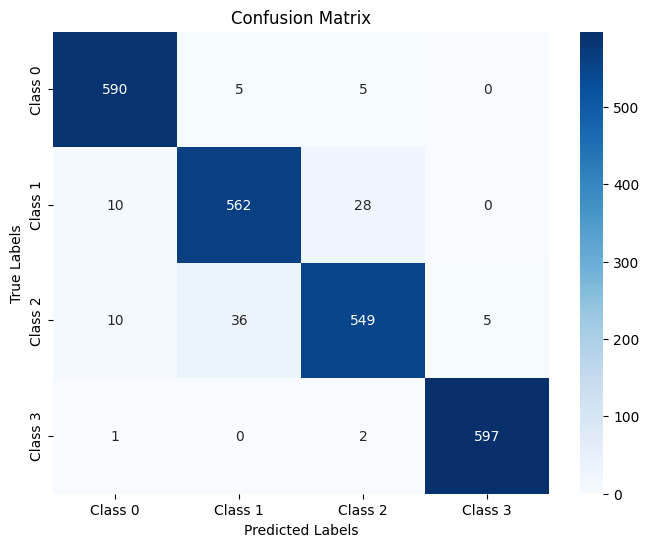

In [ ]:
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)
model.eval()

# cnf and Classification Report
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Cnf
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3']))

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.97       600
     Class 1       0.93      0.94      0.93       600
     Class 2       0.94      0.92      0.93       600
     Class 3       0.99      0.99      0.99       600

    accuracy                           0.96      2400
   macro avg       0.96      0.96      0.96      2400
weighted avg       0.96      0.96      0.96      2400



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loo

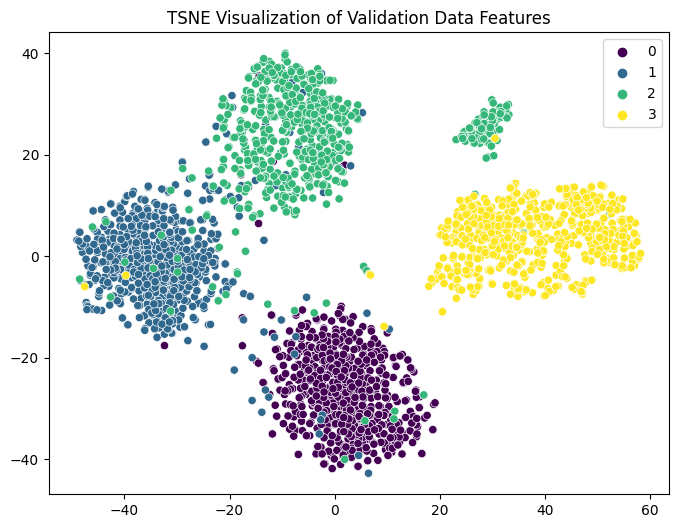

In [ ]:
# TSNE
def get_features(model, loader):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for inputs, label in loader:
            inputs = inputs.to(device)
            outputs = model.features(inputs)
            features.extend(outputs.view(outputs.size(0), -1).cpu().numpy())
            labels.extend(label.numpy())
    return np.array(features), np.array(labels)

features, labels = get_features(model, val_loader)
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", legend="full")
plt.title("TSNE Visualization of Validation Data Features")
plt.show()

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


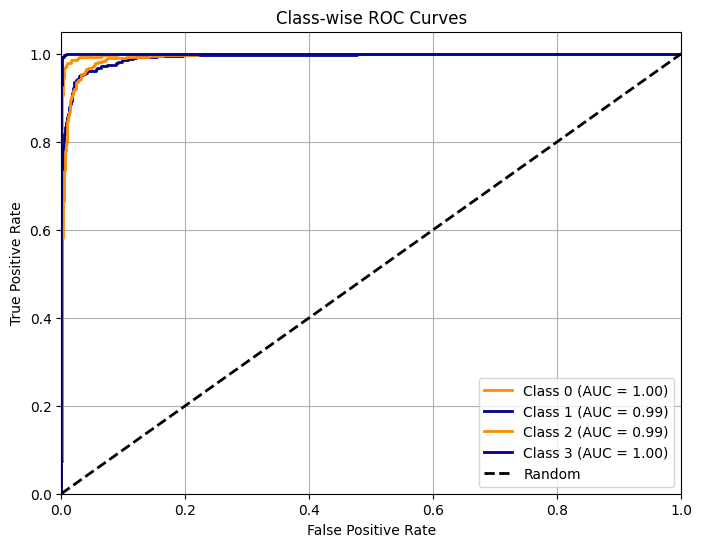


Class-wise ROC AUC Scores:
Class 0: 0.997
Class 1: 0.991
Class 2: 0.992
Class 3: 1.000


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

all_probs = []
all_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        all_probs.extend(probabilities.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

#ROC curves for each class
n_classes = 4
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['darkorange', 'darkblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Class-wise ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print AUC scores
print("\nClass-wise ROC AUC Scores:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.3f}")